# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Входные данные от банка — статистика о платёжеспособности клиентов.

Целью исследования является получение ответов на следюущие вопросы:
- есть ли зависимость между наличием детей и возвратом кредита в срок?
- есть ли зависимость между семейным положением и возвратом кредита в срок?
- есть ли зависимость между уровнем дохода и возвратом кредита в срок?
- как разные цели кредита влияют на его возврат в срок?

Описание данных:
- **children** — количество детей в семье
- **days_employed** — общий трудовой стаж в днях
- **dob_years** — возраст клиента в годах
- **education** — уровень образования клиента
- **education_id** — идентификатор уровня образования
- **family_status** — семейное положение
- **family_status_id** — идентификатор семейного положения
- **gender** — пол клиента
- **income_type** — тип занятости
- **debt** — имел ли задолженность по возврату кредитов
- **total_income** — ежемесячный доход
- **purpose** — цель получения кредита

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

Импортируем библиотеки `pandas` и `pymystem3`.

In [1]:
import pandas as pd
from pymystem3 import Mystem

Составим список возможных полных имен файла с таблицей исходных данных о заёмщиках. Загрузим первый существующий файл. В случае если ни одно полное имя файла не существует, будет выведено соответствующее предупреждение.

In [2]:
filenames = ['./data.csv', '/datasets/data.csv', 'https://code.s3.yandex.net/datasets/data.csv']

for filename in filenames:
    try:
        borrowers = pd.read_csv(filename)
        print('Таблица с данными о заёмщиках загружена из файла', filename)
        break
    except Exception:
        continue
else:
    raise SystemExit('Файл с таблицей data.csv не найден ни по одному из путей')

Таблица с данными о заёмщиках загружена из файла https://code.s3.yandex.net/datasets/data.csv


Выведем несколько первых строк загруженной таблицы.

In [3]:
borrowers.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Первое что бросается в глаза — данные о платежеспособности клиента не содеражат уникального идентификатора клиента, что не позволяет однозначно отличить двух разных клиентов со случайно совпавшими наборами данных от одного и того же клиента, занесенного в таблицу дважды. Поэтому о занесении одного и того же клиента в таблицу дважды можно судить только косвенным образом - по полному совпадению его данных. Возможно ли естественное возникновение такой ситуации? Для этого клиент должен взять в банке два кредита для одной и той же цели в такой промежуток времени, с точностью до которого определяется его трудовой стаж. Но, судя по первым строкам таблицы, данные о трудовом стаже содержат много аномалий и требуют уточнения.

Определим количество строк в таблице, количество полных дубликатов данных о клиенте и их долю от всего количества строк.

In [4]:
print('Всего строк:                    ', len(borrowers))
print('Количество дублированных строк: ', borrowers.duplicated().sum())
print('Доля дублированных строк:        {:.1%}'.format(borrowers.duplicated().sum()/len(borrowers)))

Всего строк:                     21525
Количество дублированных строк:  54
Доля дублированных строк:        0.3%


Доля полных дубликатов крайне мала. Их удаление практически не повлияет на качество проводимого исследования. Удалим эти дубликаты.

In [5]:
borrowers = borrowers.drop_duplicates().reset_index(drop=True)

Ознакомимся с краткой сводкой о таблице.

In [6]:
borrowers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21471 entries, 0 to 21470
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21471 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21471 non-null  int64  
 3   education         21471 non-null  object 
 4   education_id      21471 non-null  int64  
 5   family_status     21471 non-null  object 
 6   family_status_id  21471 non-null  int64  
 7   gender            21471 non-null  object 
 8   income_type       21471 non-null  object 
 9   debt              21471 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21471 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [7]:
borrowers.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Анализ общей информации о таблице позволяет отметить ряд ее особенностей и выбрать соответствующие методы предобработки данных:

- необходимо осуществить поиск и подсчет пропусков в каждом столбце. Если пропуски присутствуют в нескольких столбцах, следует проверить их появление на наличие зависимостей. На этапе предобработки данных пропуски, в зависимости от их доли от общего числа строк и типа данных (количественные или категориальные), следует удалить либо заменить на характерные значения;


- столбец **children** содержит информацию о количестве детей в семье клиента и имеет целочисленный тип. На этапе предобработки данных необходимо избавить данный столбец от отрицательных или слишком больших значений, если таковые имеются;


- столбец **days_employed** хранит количественные данные о трудовом стаже клиента в днях и имеет тип числа с плавающей запятой. Значения имеют ненулевую дробную часть, многие из них имеют отрицательный знак, встречаются аномально большие по модулю значения. Отметим, что частота появления отрицательных значений слишком велика для ошибки ввода. Хотелось бы установить причину их появления. Учитывая вышесказанное, на этапе предобработки данных решено поменять знак у отрицательных значений и отбросить значения неестественно большие по модулю. После чего оценить распределение преобразованных значений и, в зависимости от распределения, округлить значения до первого знака после запятой или до целых с последующей заменой типа данных на целочисленный;


- столбец **dob_years** содержит количественные целочисленные данные о возрасте клиента в годах. Значения этого столбца на этапе предобработки необходимо проверить на наличие отрицательных и неестественно больших значений. При их обнаружении решение об их удалении или замене на характерные значения будет приниматься в зависимости от их количества;


- столбцы **education** и **education_id** хранят категориальные данные об уровне образования клиента и имеют строковый и целочисленный тип соответственно. По первым строкам таблицы видно, что в столбце **education** встречаются дубликаты — одни и те же категории имеют разные стили написания. Необходимо устранить дубликаты, приведя все строки к единому стилю написания. Также требуется убедиться в том, что между значениями в данных столбцах существует строгое соответствие: каждому уникальному строковому значению категории в столбце **education** должен соответствовать только один уникальный целочисленный идентификатор в столбец **education_id**. Строки, в которых это соответствие нарушается, следует удалить на этапе предобработки данных, как ошибки;


- столбцы **family_status** и **family_status_id** хранят категориальные данные о семейном положении клиента в виде строк и целых чисел соответственно. Их предобработка полностью аналогична предобработке данных в предыдущих двух столбцах;


- столбец **gender** хранит категориальную информацию о поле клиента. Предобработка строковых значений в данном столбце подразумевает поиск и удаление дубликатов, поиск и удаление значений, которые невозможно отнести ни к одному из полов;


- столбец **income_type** содержит категориальные данные о типе занятости клиента и имеет строковый тип. На этапе предобработки необходимо найти и удалить дублированные значения;


- данные о наличии у клиента задолженности по кредиту в столбце **debt** имеют целочисленный тип и представляют собой логические значения 0 (нет) или 1 (да). Необходимо изучить уникальные значения в этом столбце. Значения, не принадлежащие множеству {0,1}, являются ошибками и должны быть удалены на этапе предобработки данных;


- количественные данные о ежемесячном доходе клиента в столбце **total_income** имеют тип числа с плавающей запятой. Необходимо проверить этот столбец на наличие отрицательных значений и явных выбросов. Для удобства восприятия можно округлить значения до целых и заменить тип на целочисленный. Размер таблицы при вычислении оценок статистических параметров позволяет пренебречь ошибками округления. Также для дальнейшего анализа потребуется категоризация данных в этом столбце;


- данные о цели получения кредита в столбце **purpose** имеют строковый тип. По смыслу они категориальные, но, судя по всему, значения заносятся в таблицу не выбором одного значения из ограниченного списка возможных, а набираются человеком "в вольном стиле". Для работы с такими данными сперва необходимо их категоризировать. Для этого предстоит выделить существующие категории, основываясь на уникальных значениях столбца. Эту задачу поможет решить лемматизация строк, ставящая в соответствие каждой строке список лемм входящих в нее слов. Если каждой категории сопоставить уникальный список лемм, это позволит объединить все значения столбца по ограниченному списку категорий.

Начнем с пропусков. Определим количество пропусков в каждом столбце.

In [8]:
# isnull() считает NaN, None, NaT
print('Количество пропусков в столбцах:')
display(borrowers.isnull().sum())

Количество пропусков в столбцах:


children               0
days_employed       2120
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2120
purpose                0
dtype: int64

Пропуски обнаружились в столбцах с струдовым стажем клиента **days_employed** и уровнем дохода клиента **total_income**. Их количество совпадает. Это наталкивает на гипотезу об их одновременном появлении. Проверим ее.

In [9]:
rows_with_nulls_number = len(borrowers[(borrowers['days_employed'].isnull()) & (borrowers['total_income'].isnull())])
print('Количество строк с пропусками:', rows_with_nulls_number)

Количество строк с пропусками: 2120


Гипотеза оказалась верна, так так количество строк, содержащих пропуски одновременно и в столбце **days_employed**, и в столбце **total_income**, совпадает с количеством пропусков в каждом из этих столбцов по отдельности.

Вычислим долю строк с пропусками в общем количестве строк.

In [10]:
print('{:.1%} строк содержат пропуски'.format(rows_with_nulls_number/len(borrowers)))

9.9% строк содержат пропуски


Вычисленная доля пропусков достаточно высока. С одной стороны, если удалить строки с пропусками, изменение размера таблицы вряд ли сильно повлияет на оценки искомых статистических параметров. С другой стороны, пропуски в количественных переменных можно заменить на характерные значения: среднее арифметическое или медианное:
- для трудового стажа клиента **days_employed** в качестве характерного значения подходит арифметическое среднее, так как максимальное значение трудового стажа ограничено естественными причинами;
- для ежемесячного дохода клиента **total_income** в качестве характерного значения лучше использовать медиану, так как у некоторых клиентов даход может иметь значение, значительно выбивающееся из общего ряда, а медиана менее восприимчива к таким выбросам, нежели выборочное среднее. В дальнейшем заменим все пропуски в графе ежемесячного дохода клиента на его медианное значение.

Проанализируем данные во всех столбцах на наличие аномалий.

Столбец **children**.

In [11]:
borrowers['children'].value_counts()

 0     14107
 1      4809
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Среди данных о количестве детей в семье клиента встречаются аномальные значения -1 и 20. -1 — недопустимое значение. Можно предположить, что это ошибка ввода, но, так как общее количество таких значений по сравнению с размером таблицы невелико, можно просто удалить содержащие их строки и не отвлекаться на гипотезы об их появлении. Значение 20 теоретически допустимо (например, какая-то часть детей приемная), но число семей с 20 детьми превышает суммарное количество семей с 4 и 5 детьми. Что странно. Далее удалим и эти строки тоже. Общее количество удаленных строк из-за аномалий в столбце **children** будет равно 123, что незначительно уменьшит размер таблицы.

Столбец **days_employed**.

Для анализа данного столбца создадим его копии. Поменяем знаки у отрицательных значений и для удобства пересчитаем значения из дней в годы.

In [12]:
days_employed_column = borrowers['days_employed'].abs()
years_employed_column = days_employed_column / 365.25

Выведем округленные минимальное и максимальное знчение трудового стажа клиента в днях.

In [13]:
# Знаю, что можно и так days_employed_column.round().max(), но так в общем случае должно быть быстрее
print('Минимальное значение трудового стажа клента, дней:', round(days_employed_column.min()))
print('Максимальный значение трудового стажа клента, дней:', round(days_employed_column.max()))

Минимальное значение трудового стажа клента, дней: 24
Максимальный значение трудового стажа клента, дней: 401755


Сколько-сколько?

In [14]:
print('Максимальный значение трудового стажа клента, лет:',  round(years_employed_column.max()))

Максимальный значение трудового стажа клента, лет: 1100


1100 лет? Что сказать... press F to pay respect.

Раз так, проверим столбец на наличие неестественно высоких значений более скрупулезно. По данным из различных открытых источников средний трудовой стаж в России для граждан 55-60 лет составляет 32-34.5 года. Возьмем с запасом — 60 лет.

In [15]:
years_employed_threshold = 60

 Определим, какое количество значений в столбце **days_employed** превышает этот порог и какова их доля.

In [16]:
heroes_of_labor_number =\
years_employed_column[years_employed_column > years_employed_threshold].count()
print('Количество клиентов со стажем более 60 лет:', heroes_of_labor_number)
print('Доля клиентов со стажем более {} лет:       {:.1%}'.\
      format(years_employed_threshold, heroes_of_labor_number / len(borrowers)))

Количество клиентов со стажем более 60 лет: 3445
Доля клиентов со стажем более 60 лет:       16.0%


Выведем топ 5 значений трудового стажа клиентов в годах.

In [17]:
years_employed_column.sort_values(ascending=False).head(5)

6950    1099.946339
9997    1099.837951
7660    1099.726471
2156    1099.724755
7790    1099.695688
Name: days_employed, dtype: float64

Все они превышают 1099 лет. Это явно аномально большие значения.

Построим гистограмму, чтобы определить форму распределения количества клиентов по годам трудового стажа. Максимальное значение стажа ограничим установленным ранее порогом. Шаг ячеек гистограммы — 5 лет.

<AxesSubplot:>

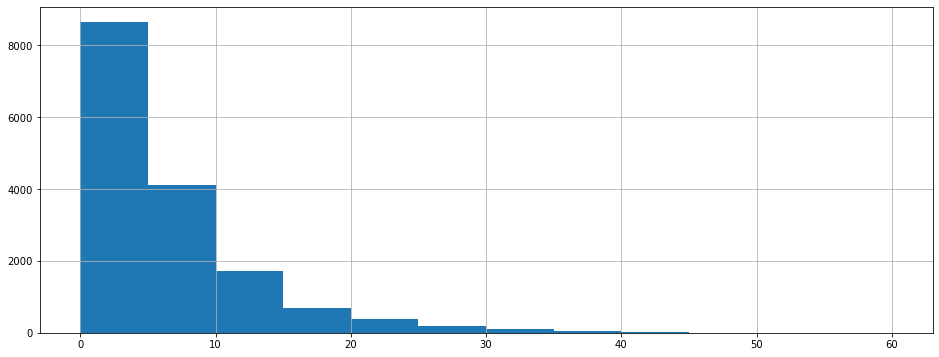

In [18]:
hist_bins_step = 5
years_employed_column.hist(bins=range(0, years_employed_threshold + hist_bins_step, hist_bins_step), figsize=(16,6))

Гистограмма имеет ожидаемую форму. Чаще всего клиенты обращались в банк за кредитом в течении первых 5 лет работы. Это можно объяснить тем, что молодые клиенты, обретя постоянный заработок, активно приобретают собственное имущество (квартира, автомобиль), повышают уровень своего образования, а также создают семьи. С ростом трудового стажа клиентов частота их обращения в банк за кредитом падает.

Зависимость возврата кредита в строк от размера трудового стажа клиента не является целью исследования. Поэтому не будем удалять из таблицы строки с аномальными значениями трудового стажа, так как их количество достаточно велико и может повлечь удаление важных целевых данных. Далее для удобства визуального восприятия округлим все значения до целых и приведем их тип к целочисленному.

Что касается пропусков, заменим их на характерные медианные значения. Среднее арифметическое здесь не подойдет, так как в выборе присутствует значительно количество необъяснимо больших значений.

Столбец **dob_years**.

Определим минимальый и максимальнй возрасты клиента в годах.

In [19]:
print('Минимальный возраст клента, лет:', borrowers['dob_years'].min())
print('Максимальный возраст клента, лет:', borrowers['dob_years'].max())

Минимальный возраст клента, лет: 0
Максимальный возраст клента, лет: 75


К максимальному значению претензий нет, а вот минимальное смущает. Строго говоря, гражданин Российской Федерации в особых случаях может получить дееспособность в 16 лет. Маловероятно, что в таком возрасте банк выдаст клиенту кредит, но все же выберем в качестве нижней границы именно этот возраст. Проверим, какое количество клиентов в таблице имеют взраст ниже этого порога.

In [20]:
min_dob_years_threshold = 16

Проверим, какое количество клиентов в таблице имеют взраст ниже этого порога.

In [21]:
borrowers[borrowers['dob_years'] < min_dob_years_threshold]['dob_years'].count()

101

Немало. Построим гистограмму распределения количества клиентов по возрастам с шагом один год.

<AxesSubplot:>

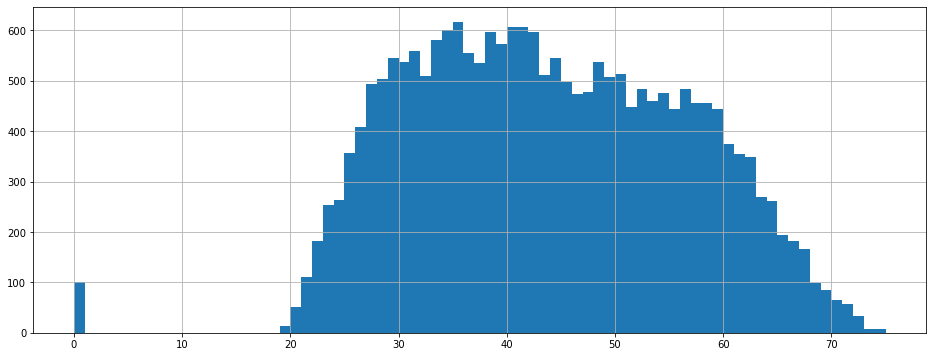

In [22]:
borrowers['dob_years'].hist(bins=range(0, borrowers['dob_years'].max() + 1, 1), figsize=(16,6))

Судя по гистограмме, все значения возрастов клиента меньше 16 лет строго равны 0. Исключим эти значения из столбца и снова выведем минимальный возраст клиента банка.

In [23]:
borrowers[borrowers['dob_years'] != 0]['dob_years'].min()

19

Отлично. Далее можно удалить строки с 0 значением возраста клиента банка, либо заменить 0 на характерное значение для данного столбца. Для возраста подойдет как среднее арифметическое, так и медиана.

Так как данные о возрасте клиента не относятся напрямую к целям исследования, удалять 0 значения, не смотря на их малое количество, все же не будем. По мере анализа вместе с аномальными данными из друих столбцов общее количество удаленных строк может оказаться достаточно большим. Поэтому выберем второй подход, а в качестве характерного значения — медиану. 

Столбцы **education** и **education_id**.

Ознакомимся с их уникальными значениями.

In [24]:
borrowers['education'].value_counts()

среднее                13705
высшее                  4710
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   273
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

In [25]:
borrowers['education_id'].value_counts()

1    15188
0     5251
2      744
3      282
4        6
Name: education_id, dtype: int64

Избавимся от дубликатов в столбце со строковыми значениями уровня образования клиента. Еще раз выведем список уникальных начений.

In [26]:
borrowers['education'].str.lower().value_counts()

среднее                15188
высшее                  5251
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

Количественно уникальные целочисленные идентификаторы в столбце **education_id** распределены так же, как и уникальные строковые значения в столбце **education**. Это не гарантирует строгого соответствия каждого уникального идентификатора только одному уникальному строковому значению. Чтобы убедиться в строгом соответствии проведем дополнительную проверку.

In [27]:
borrowers_copy = borrowers
borrowers_copy['education'] = borrowers_copy['education'].str.lower()
borrowers_copy.groupby('education')['education_id'].nunique()

education
высшее                 1
начальное              1
неоконченное высшее    1
среднее                1
ученая степень         1
Name: education_id, dtype: int64

Строгое соответствие.

Что касается столбцов **education** и **education_id**, то на этапе предобработки данных переведем все символы в столбце **education** в нижний регистр для устранения дублированных значений. После чего столбцы будут полностью повторять друг друга, что делает возможным удаление одного из них. Оставим столбец **education**, так как строковые значений проще воспринимать.

Столбцы **family_status** и **family_status_id**.

In [28]:
borrowers['family_status'].value_counts()

женат / замужем          12344
гражданский брак          4163
Не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

В целом все благопристойно. Для лучшего визуального восприятия на этапе предобработки данных переведем все символы в нижний регистр.

In [29]:
borrowers['family_status_id'].value_counts()

0    12344
1     4163
4     2810
3     1195
2      959
Name: family_status_id, dtype: int64

Убедимся, что каждому уникальному значению идентификатора в столбце **family_status_id** соответствует только одно уникальное строковое значение **family_status**.

In [30]:
borrowers_copy.groupby('family_status')['family_status_id'].nunique()

family_status
Не женат / не замужем    1
в разводе                1
вдовец / вдова           1
гражданский брак         1
женат / замужем          1
Name: family_status_id, dtype: int64

В таблице не существует строк с нарушением искомого соответствия. Исследуемые столбцы повторяют друг друга. на этапе предобработки данных удалим столбец с идентификаторами и оставим столбец со строковыми значениями, так как их проще визуально воспринимать.

Столбец **gender**.

In [31]:
borrowers['gender'].value_counts()

F      14189
M       7281
XNA        1
Name: gender, dtype: int64

Есть неопределившийся. Удалим его при предобработке от греха подальше. Один в поле не воин.

Столбец **income_type**.

In [32]:
borrowers['income_type'].value_counts()

сотрудник          11091
компаньон           5080
пенсионер           3837
госслужащий         1457
безработный            2
предприниматель        2
в декрете              1
студент                1
Name: income_type, dtype: int64

Предобработка данных в этом столбце не требуется.

Столбец **debt**.

In [33]:
borrowers['debt'].value_counts()

0    19730
1     1741
Name: debt, dtype: int64

Предобработка данных в этом столбце не требуется.

Столбец **total_income**.

In [34]:
print('Минимальное значение ежемесячного дохода клиента:  {:.2f}'.format(borrowers['total_income'].min()))
print('Максимальное значение ежемесячного дохода клиента: {:.2f}'.format(borrowers['total_income'].max()))
print('Среднее значение ежемесячного дохода клиента:      {:.2f}'.format(borrowers['total_income'].mean()))
print('Медианное значение ежемесячного дохода клиента:    {:.2f}'.format(borrowers['total_income'].median()))

Минимальное значение ежемесячного дохода клиента:  20667.26
Максимальное значение ежемесячного дохода клиента: 2265604.03
Среднее значение ежемесячного дохода клиента:      167422.30
Медианное значение ежемесячного дохода клиента:    145017.94


In [35]:
borrowers['total_income'].describe().round(2)

count      19351.00
mean      167422.30
std       102971.57
min        20667.26
25%       103053.15
50%       145017.94
75%       203435.07
max      2265604.03
Name: total_income, dtype: float64

In [36]:
print('Пять минимальных значений ежемесячного дохода клиентов:')
borrowers['total_income'].sort_values(ascending=True).head(5)

Пять минимальных значений ежемесячного дохода клиентов:


14562    20667.263793
12989    21205.280566
16147    21367.648356
1598     21695.101789
14254    21895.614355
Name: total_income, dtype: float64

In [37]:
print('Пять максимальных значений ежемесячного дохода клиентов:')
borrowers['total_income'].sort_values(ascending=False).head(5)

Пять максимальных значений ежемесячного дохода клиентов:


12396    2.265604e+06
19562    2.200852e+06
9163     1.726276e+06
20759    1.715018e+06
17147    1.711309e+06
Name: total_income, dtype: float64

Минимальное и максимальное значения ежемесячного дохода клиентов различаются на 2 порядка. "Хвосты" отсортированной выборки не содеражат явных выбросов. Такой экспресс-поиск выбросов может давать ложный результат, поэтому, строго говоря, наличие выбросов не исключается.

Обратим внимание на достаточно близкие значения арифметического среднего и медианны. Это означает, что в выборке нет перевеса в сторону самых маленьких или самых больших ежемесячных доходов: ни те, ни другие не "перетягивают" арифметическое среднее в свою сторону.

Минимальная зарплата равна 20667.263793, ее дробная часть в сравнение с целой частью пренебрежима мала, поэтому для удобства восприятия далее округлим все значения в данном столбце до целых значений и приведем их тип к целочисленному.

Выделим категории, подходящие для объединения уровней ежемесячного дохода клиентов:
- низкий — ежемесячный доход в диапазоне [0, 50000);
- ниже среднего — ежемесячный доход в диапазоне [50000,100000);
- средний — ежемесячный доход в диапазоне [100000,250000);
- выше среднего — ежемесячный доход в диапазоне [250000,500000);
- ~~чтоб я так жил~~ высокий — ежемесячный доход в диапазоне [500000,∞).

п.с. Подбирал "на глаз", чтобы распределение получилось более-менее симметричное.

Столбец **purpose**.

In [38]:
borrowers['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Проанализируем уникальные значения в данном столбце. Можно выделить следующие категории:
- жилье;
- автомобиль;
- образование;
- свадьба;
- недвижимость.

Если предположить, что в таблицу заносятся данные о гражданах России, то такую цель кредита как "покупка жилой недвижимости" следует отнести к категории "жилье" согласно Ст. 15 Жилищного кодекса Российской Федерации (источник: http://jkodeksrf.ru/rzd-1/gl-2/st-15-jk-rf). "Строительство собственной недвижимости" согласно этому же источнику следует отнести к категории "недвижимость".

Символы всех строк имеют нижний регистр.

Сохраним размер таблицы до предобработки данных.

In [39]:
initial_table_len = len(borrowers)
initial_table_len

21471

**Вывод**

Была проанализирована таблица данных о платежеспособности клиентов банка. Таблица не содержит уникальных идентификаторов клиентов, по которым можно было однозначно судить о дублировании информации. Поэтому первичный поиск дубликатов был проведен по косвенным признакам — полному совпадению всех данных о клиенте. Общая доля таких дубликатов составила 0.3%, они были удалены.

Анализ оставшихся столбцов требует следующих действий на этапе предобработки данных:
- данные о количестве детей в семье клиента в столбце **children** содержат незначительную долю аномальных значений. Строки, содержащие аномальные данные, подлежат удалению;


- значения трудового стажа клиента в столбце **days_employed** странным образом искажены. Причину этого было бы неплохо уточнить. Многие значения имеют отрицательны знак, более 16% значений по модулю недопустимо велики. Было принятно не удалять строки с аномальными значениями, так как они не связаны напрямую с целями исследования. Тем не менее значения **days_employed** будут скорректированы на этапе предобработки: отрицательные поменяют знак, тип значений будет изменен на целочисленный;

- данные об уровне образования клиента в столбцах **education** и **education_id** проверены на наличие дубликатов и на соответствие их уникальных значений друг другу. Для удаления дубликатов в столбце **education** на этапе предобработки все значения следует перевести в нижний регистр. После этого столбцы будут полностью повторять друг друга;


- данные о семейном положении клиента в столбцах **family_status** и **family_status_id** проверены на наличие дубликатов и на соответствие их уникальных значений друг другу. Столбец **family_status** не содержит дубликатов, но для улучшения визуального восприятия далее все его значения будут переведены в нижний регистр. Столбцы полностью дублируют друг друга;


- столбец с данными о ежемесячном доходе клиента **total_income** имеет большую долю пропусков  — 9.1%. На этапе предобработки пропуски будут заменены на медианное значение ежемесячного дохода, вычисленное по существующим значениям;


- в столбце пола клиента **gender** есть одно неидентифицируемое значение, строку с которым проще удалить при предобработке, чем разгадать;


- данные о цели получения кредита в столбце **purpose** были также проанализированы. Принято решение разбить их на пять категорий: жилье, автомобиль, образование, свадьба, недвижимость. Для категоризации данных в этом столбце потребуется лемматизации значений;


- остальные столбцы не требуют предобработки значений.

## Шаг 2. Предобработка данных

### Обработка пропусков и аномальных значений

Удалим строки с аномальными значениями в столбце **children**, убедимся, что остались только корректные данные.

In [40]:
borrowers.drop(borrowers[(borrowers['children']==-1) | (borrowers['children']==20)].index, inplace=True)
borrowers.reset_index(drop=True, inplace=True)
display(borrowers['children'].value_counts())
print('Количество удаленных строк {}:'.format(initial_table_len-len(borrowers)))

0    14107
1     4809
2     2052
3      330
4       41
5        9
Name: children, dtype: int64

Количество удаленных строк 123:


Исправим отрицательные значения трудового стажа в днях на положительные в столбец **days_employed**.

In [41]:
borrowers['days_employed'] = borrowers['days_employed'].abs()

Вычислим медианы для столбцов с количеством дней трудового стажа **days_employed**, возрастом **dob_years** и ежемесячным доходом **total_income** клиента.

In [42]:
# По умолчанию median() исключает из расчета значения NA / NULL
days_employed_median = borrowers['days_employed'].median()
dob_years_median = borrowers['dob_years'].median()
total_income_median = borrowers['total_income'].median()
print('Медианное значение количества дней трудового стажа клиента:', days_employed_median)
print('Медианное значение возраста клиента, лет:                  ', dob_years_median)
print('Медианное значение ежемесячного дохода клиента:            ', total_income_median)

Медианное значение количества дней трудового стажа клиента: 2195.2515915238964
Медианное значение возраста клиента, лет:                   42.0
Медианное значение ежемесячного дохода клиента:             145020.80127962783


Заменим пропуски в столбцах **days_employed**, **total_income** на медианну, убедимся, что пропуски исчезли.

In [43]:
borrowers.loc[borrowers['days_employed'].isnull(), 'days_employed'] = days_employed_median
borrowers.loc[borrowers['total_income'].isnull(), 'total_income'] = total_income_median
borrowers.isnull().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

Заменим 0 значения в столбце **dob_years** на медиану, убедимся в их исчезновении.

In [44]:
borrowers.loc[borrowers['dob_years'] == 0, 'dob_years'] = int(dob_years_median)
len(borrowers[borrowers['dob_years'] == 0])

0

Приведем все символы строковых значений столбца **family_status** к нижнему регистру.

In [45]:
borrowers['education'] = borrowers['education'].str.lower()
borrowers['education'].value_counts()

среднее                15091
высшее                  5228
неоконченное высшее      741
начальное                282
ученая степень             6
Name: education, dtype: int64

Аналогичным образом преобразуем данные в столбец **family_status**.

In [46]:
borrowers['family_status'] = borrowers['family_status'].str.lower()
borrowers['family_status'].value_counts()

женат / замужем          12266
гражданский брак          4146
не женат / не замужем     2796
в разводе                 1189
вдовец / вдова             951
Name: family_status, dtype: int64

Удалим строку из таблицы с непонятным значением пола клиента **gender**. Проверим результат.

In [47]:
borrowers.drop(borrowers[borrowers['gender']=='XNA'].index, inplace=True)
borrowers.reset_index(drop=True, inplace=True)
borrowers['gender'].value_counts()

F    14107
M     7240
Name: gender, dtype: int64

**Вывод**

При обработке пропусков и аномальных значений из таблицы были удалены 123 строки, содержащие недопустимые величины в **children**. У отрицательных значений трудового стажа клиентов **days_employed** знак был изменен на положительный. Пропуски в столбцах **days_employed** и **total_income** были заменены на их медианные значения, равные 2195.2515915238964 и 145020.80127962783 соответственно. В столбцах **education** и **family_status** названия категорий были приведены к общему стилю написания — в нижнем регистре. В столбце **gender** было удалено только одно неидентифицируемое значение 'XNA'.

### Замена типа данных

Округлим до целого значения столбца **days_employed** и преобразуем их тип в целочисленный.

In [48]:
borrowers['days_employed'] = borrowers['days_employed'].apply(round)
borrowers['days_employed'].astype(int)
borrowers['days_employed'].dtypes

dtype('int64')

Аналогичным образом преобразуем столбец **total_income**.

In [49]:
borrowers['total_income'] = borrowers['total_income'].apply(round)
borrowers['total_income'].astype(int)
borrowers['total_income'].dtypes

dtype('int64')

**Вывод**

Изменения типа данных были осуществлены в стролбцах **days_employed** и **total_income**. Теперь это целые числа. Перед приведением типа к целочисленному значения округлялись.

### Обработка дубликатов

Изменим регистр всех символов в столбце **education** на нижний. Убедимся, что в нем не осталось дубликатов.

In [50]:
borrowers['education'] = borrowers['education'].str.lower()
borrowers['education'].value_counts()

среднее                15091
высшее                  5228
неоконченное высшее      740
начальное                282
ученая степень             6
Name: education, dtype: int64

**Вывод**

Количество дублированных строк в таблице рассматривалось и обрабатывалось на этапе ее предварительного анализа. Дубликаты значений в отдельных столбцах наблюдались в **education** и **purpose**. В **education** удаление дубликатов было достигнуто переводом символов всех строковых значений в общий (нижний) регистр, а вот обработка **purpose** встроенными методами библиотеки Pandas оказалсь невозможной. Для категоризации значений в столбце **purpose** воспользуемся инструментами библиотеки PyMystem.

### Лемматизация

Составим словарь, ключами которого будут уникальные строковые значения целей получения кредита из столбца **purpose**, а значениями — списки лемматизированных слов в строке ключа. Это позволит не вычислять заново список лемматизированных слов для повторяющихся значений столбца **purpose**.

In [51]:
m = Mystem()

purposes_lemmas_dict = {k:m.lemmatize(k) for k in borrowers['purpose'].unique()}

**Вывод**

Уникальные значения строк в столбце **purpose** были лемматизированы с помощью библиотеки `PyMystem`. Списки их лемматизированных слов сохранены в переменной-словаре для ускорения вычисления последующей категоризации данных в этом столбце.

### Категоризация данных

Столбец **purpose**.

Определим принадлежность каждого значения в столбце с информацией о целях кредита **purpose** к одной из выделенных на этапе предварительного анализа таблицы категорий. Найденные значения категорий добавим в таблицу в виде столбца с именем **purpose_category**.

In [52]:
def purpose_category(purpose):
    purposes_lemmas = purposes_lemmas_dict[purpose]
    if 'жилье' in purposes_lemmas:
        return 'жилье'
    elif 'автомобиль' in purposes_lemmas:
        return 'автомобиль'
    elif 'образование' in purposes_lemmas:
        return 'образование'
    elif 'свадьба' in purposes_lemmas:
        return 'свадьба'
    elif 'недвижимость' in purposes_lemmas:
        return 'недвижимость'
    else:
        return 'неопознанная категория'

borrowers['purpose_category'] = borrowers['purpose'].apply(purpose_category)

Проверим на сякий случай, не оказалось ли в новоиспеченном столбце значений 'неопознанная категория'.

In [53]:
#borrowers[borrowers['purpose_category'] == 'неопознанная категория']['purpose_category'].sum()
display(borrowers['purpose_category'].value_counts())

недвижимость    6315
жилье           4438
автомобиль      4281
образование     3989
свадьба         2324
Name: purpose_category, dtype: int64

Отлично! Каждому значению в столбце **purpose** нашлась своя категория.

Столбец **total_income**.

Данные о ежемесячном доходе клиента в столбце **total_income** для удобства дальнейшего анализа также необходимо объединить по оговоренным ранее категориям.

In [54]:
def total_income_category(total_income):
    if 0 <= total_income < 50000:
        return 'низкий'
    elif 50000 <= total_income < 100000:
        return 'ниже среднего'
    elif 100000 <= total_income < 250000:
        return 'средний'
    elif 250000 <= total_income < 500000:
        return 'выше среднего'
    else: #if total_income >= 500000
        return 'высокий'

borrowers['total_income_category'] = borrowers['total_income'].apply(total_income_category)

Проверим результат.

In [55]:
display(borrowers['total_income_category'].value_counts())

средний          14107
ниже среднего     4073
выше среднего     2574
низкий             371
высокий            222
Name: total_income_category, dtype: int64

**Вывод**

Была проведена категоризация значений в столбцах с информацией о цели кредита **purpes** и о ежемесячном доходе клиента **total_income**. Значения категорий сохранены в таблице в столбцах **purpes_category** и **total_income_category** соответственно.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Для ответа на этот вопрос достаточно сгруппировать таблицу по количеству детей в семье клиента в столбце **children**, после чего для каждой группы вычислить отношение количества задолженностей по кредиту к общему количеству кредитов. Первую величину для каждой группы можно получить суммированим значений столбца **debt**, вторую — подсчетом количества строк. Вычислим для каждой группы и сохраним в столбцах **debtors, %** и **not a debtors, %** соответственно процент должников и процент клиентов, которые вернули кредиты в срок. Результирующая таблица отсортирована по убыванию значений в столбце **debtors, %**.

In [56]:
borrowers_by_children = borrowers.groupby('children').agg({'debt':['sum', 'count']})
borrowers_by_children['debtors, %'] =\
round(100 * borrowers_by_children['debt']['sum'] / borrowers_by_children['debt']['count'], 1)
borrowers_by_children['not a debtors, %'] = 100 - borrowers_by_children['debtors, %']
borrowers_by_children.sort_values(by='debtors, %', ascending=False)

debt        debtors, % not a debtors, %
           sum  count                            
children                                         
4            4     41        9.8             90.2
2          194   2052        9.5             90.5
1          444   4809        9.2             90.8
3           27    330        8.2             91.8
0         1063  14106        7.5             92.5
5            0      9        0.0            100.0

**Вывод**

Количество клиентов с 5 детьми всего 9 штук. Это крайне малый для анализа размер выборки. В нашем случае среди клиентов с 5 детьми вообще не оказалось должников. Эти данные стоило отбросить еще на этапе предобработки данных.

Группа клиентов с 4 детьми тоже немногочисленна, хотя и превышает численность группы клиентов с 5 детьми примерно в 4 раза. Из-за малого размера она с большой вероятностью также может оказаться нерепрезентативной, поэтому вычисленный для нее процент должников необходимо воспринимать с учетом данного факта.

Остальные группы достаточно многочисленны.

Небольшие доли должников 9.8%, 9.5%, 9.2% приходятся на клиентов с 4, 2 и 1 ребенком в семье соответственно. На 4 месте находятся клиенты с 3 детьми (8.2% должников). А меньше всего должников среди клиентов без детей (7.5% должников).

Если бы не клиенты с 3 детьми, можно было бы утверждать, что количество детей в семье клиента и шанс, что у него будут проблемы с возвратом кредита в срок, прямо пропорциональны.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

Проведем вычисления, аналогичные предыдущему пункту, с той лишь разницей, что теперь для группировки значений будем использовать столбец с данными о семейном положении клиента **family_status**.

In [57]:
borrowers_by_family_status = borrowers.groupby('family_status').agg({'debt':['sum', 'count']})
borrowers_by_family_status['debtors, %'] =\
round(100 * borrowers_by_family_status['debt']['sum'] / borrowers_by_family_status['debt']['count'], 1)
borrowers_by_family_status['not a debtors, %'] = 100 - borrowers_by_family_status['debtors, %']
borrowers_by_family_status.sort_values(by='debtors, %', ascending=False)

debt        debtors, % not a debtors, %
                       sum  count                            
family_status                                                
не женат / не замужем  273   2796        9.8             90.2
гражданский брак       385   4145        9.3             90.7
женат / замужем        927  12266        7.6             92.4
в разводе               84   1189        7.1             92.9
вдовец / вдова          63    951        6.6             93.4

**Вывод**

Больше всего должников среди клиентов, не состоящих в браке (9.8 %). Далее в направлении убывания следуют клиенты, состоящие в гражданском или зарегистрированном браках. Процент должников среди них соответственно 9.3% и 7.6%. Клиенты, находящиеся в разводе находятся на предпоследнем месте, среди них 7.1% должников. Вдовцы и вдовы имеют самый малый процент должников (6.6%).

Наблюдается определенное разногласие с предыдущим исследованием, в котором клиенты без детей были на последнем месте среди должников (7.5%). Здесь же клиенты с семейным положением "не женат / не замужем", что с большой вероятностью предполагает  отсутствие детей (приемные дети у незамужних достаточно редкое явление, а все, кто в разводе, выделены в соответствующую категорию), наоборот находятся на первом месте. Этот факт требует дополнительного исследования.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Повторим расчеты, используя для группировки столбец с категориями уровня ежемесячного дохода клиента **total_income_category**.

In [58]:
borrowers_by_family_status = borrowers.groupby('total_income_category').agg({'debt':['sum', 'count']})
borrowers_by_family_status['debtors, %'] =\
round(100 * borrowers_by_family_status['debt']['sum'] / borrowers_by_family_status['debt']['count'], 1)
borrowers_by_family_status['not a debtors, %'] = 100 - borrowers_by_family_status['debtors, %']
borrowers_by_family_status.sort_values(by='debtors, %', ascending=False)

debt        debtors, % not a debtors, %
                        sum  count                            
total_income_category                                         
средний                1184  14107        8.4             91.6
ниже среднего           331   4073        8.1             91.9
выше среднего           180   2574        7.0             93.0
высокий                  14    222        6.3             93.7
низкий                   23    371        6.2             93.8

**Вывод**

Наибольший процент должников среди клиентов со средним уровнем достатка (8.4%). Процент должников убывает по мере удаления категории ежемесячного дохода клиента от среднего значения.

Самый малый процент должников среди самых малообеспеченных клиентов (6.2%). Это можно объяснить тем, что при низком уровне достатка люди берут кредиты крайне осторожно, максимально снижая риски оказаться в кредитной кабале. В кризисное время адекватный малообеспеченный человек с большей вероятностью вовсе откажется от кредита, нежели будет рисковать с трудом накопленным имуществом.

Второй по величине процент должников среди самых обеспеченных клиентов (6.3%). Как правило такие люди умеют распоряжаться своими деньгами и просчитывать риски.

Средний класс в спокойное время часто задирает свой уровень потребления за счет кредитов. Но также часто оказывается в зоне риска в кризисное время. Возможно поэтому доля должников среди клиентов со средним уровнем ежемесячного дохода самая высокая.

- Как разные цели кредита влияют на его возврат в срок?

Используем для группировки столбец с категориями целей получения кредита **purpose_category**.

In [59]:
borrowers_by_family_status = borrowers.groupby('purpose_category').agg({'debt':['sum', 'count']})
borrowers_by_family_status['debtors, %'] =\
round(100 * borrowers_by_family_status['debt']['sum'] / borrowers_by_family_status['debt']['count'], 1)
borrowers_by_family_status['not a debtors, %'] = 100 - borrowers_by_family_status['debtors, %']
borrowers_by_family_status.sort_values(by='debtors, %', ascending=False)

debt       debtors, % not a debtors, %
                  sum count                            
purpose_category                                       
автомобиль        400  4281        9.3             90.7
образование       369  3989        9.3             90.7
свадьба           183  2324        7.9             92.1
недвижимость      472  6315        7.5             92.5
жилье             308  4438        6.9             93.1

**Вывод**

В данной категории лидерами среди должников выступают клиенты, бравшие кредиты на автомобиль или образование. В обоих случаях процент должников составил 9.3%. На 2 и 3 местах клиенты с кредитами на свадьбу (7.9%) и недвижимость (7.5%). На последнем месте клиенты с кредитом на жилье (6.9%).

Можно предположить, что к кредиту на собственное жилье клиенты относятся наиболее ответственно и более скрупулезно просчитывают свою возможность погасить его в срок.

Трудности с погашением в срок кредита на автомобиль можно связать с неучтенными клиентом рисками поломки, аварии, угона приобретенного в кредит автомобиля.

## Шаг 4. Общий вывод

Было проведено исследование статистики платежеспособности клиентов банка в возрасте от 19 до 75 лет, имеющих различные семейное положение, количество детей, трудовой стаж, должность, уровни образования и ежемесячного дохода, цели кредита, а также ключевой признак — наличия задолженности перед банком по кредитам. Целью исследования было установление связей:


- между наличием детей и возвратом кредита в срок;


- между семейным положением и возвратом кредита в срок;


- между уровнем дохода и возвратом кредита в срок;


- целью кредита и возвратом кредита в срок.

Исходные данные были представлены в виде таблицы размером 21525 строк, содержащей значительное количество пропусков, аномальных значений и дубликатов. Поэтому перед проведением исследования был осуществлен анализ исходных данных и выбор путей их предварительной обработки.

На этапе предобработки данных из таблицы было удалено 124 строки, что составляет примерно 0.58% от ее первоначального размера. Из этих 124 строк 123 строки были удалены из-за некорректных значений в столбце с количеством детей в семье клиента **children**. Замена этих значений на характерные не представлялась возможной из-за специфики признака: малый разброс значений, целочисленный тип. Еще одна строка была удалена из-за неидентифицируемого значения в столбце **gender**.

В столбцах **days_employed** и **income_type** пропуски (в общей сложности 2120 штук) заменялись на характерные значения количественных данных. В данном исследовании — на медианы. А в столбце **dob_years** на медиану заменялись нулевые значения.

Дубликаты в строковых столбцах **education** и **family_status** устранялись переводом всех значений в нижний регистр.

Тип данных некоторых числовых столбцов был изменен для повышения удобочитаемости таблицы.

Особым случаем стал столбец **purpose**, хранящий строковые значения, заполняемые вручную. Их категоризация осуществлялась с помощью лемматизации значений инструментами библиотеки `PyMystem`.

В результате проведенного исследования удалось установить следующие закономерности:


- наибольший шанс не вернуть в срок кредит 9.8%, 9.5%, 9.2% у клиентов 4, 2 и 1 ребенком в семье соответственно. Далее следуют клиенты с 3 детьми (8.2% должников), а меньше всего должников среди клиентов без детей (7.5%). Клиентов с 5 детьми в семье на всю таблицу оказалось всего 9, поэтому говорить о статистической значимости процента должников среди них не приходится;


- по семейному положению больше всего должников среди холостых и незамужних (9.8%). Чуть меньше должников у клиентов, состоящих в гражданском (9.3%) или зарегистрированном (7.6%) браках. Еще лучше отдают кредиты клиенты, находящиеся в разводе (7.1% должников). Вдовцы и вдовы имеют самый малый процент должников (6.6%). Стоит отметить разногласие с предыдущим исследованием, в котором клиенты без детей были на последнем месте среди должников (7.5%). Здесь же клиенты с семейным положением "не женат / не замужем" наоборот находятся на первом месте. Этот факт требует дополнительного исследования;


- по уровню достатка должников больше всего среди клиентов со средним уровнем достатка (8.4%), далее идут уровни ежемесячного дохода ниже (8.1% должников) и выше (7.0% должников) среднего. Самые хорошо (6.3% должников) и плохо (6.2% должников) обеспеченные клиенты занимают два последних места;


- в по цели кредита должники выстроились следующим образом. Авангард формируют клиенты, бравшие кредиты на автомобиль или образование. В обоих случаях процент должников составляет 9.3%. На 2 и 3 местах клиенты с кредитами на свадьбу (7.9% должников) и недвижимость (7.5% должников). На последнем месте клиенты с кредитом на жилье (6.9% должников).

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.